# Предсказание функции $sin(y)$

Кудрявцев Николай Михайлович. КИ19-09Б, 031940750

Обучим нейронную сеть с помощью библиотеки **PyTorch**.

Нейросеть будет решать задачу регресии - предсказания некоторого вещественного числа.  
Мы попытаемся предсказать функцию $sin(y)$.

In [33]:
import matplotlib.pyplot as plt
import matplotlib
import torch

matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

# Тренировочный датасет
Необходимо составить тренировочный датасет.

Возьмем 100 точек из равномерного распределения от 0 до 100 - это будут иксы нашего графика, нормируем их с помощью умножения на *20* и вычитания *10*.
Игреки нашего графика - это синусы от точек-иксов.

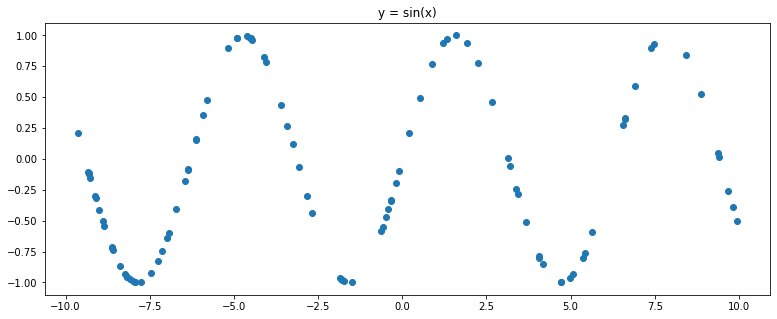

In [34]:
x_train = torch.rand(100) # Возьмем 100 точек из равномерного распределения от 0 до 100.
x_train = x_train * 20 - 10 # X-ы графика
y_train = torch.sin(x_train) # Y-ки графика - синусы от иксов

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title("y = sin(x)");

Так как обучающая выборка выглядит слишком просто, добавим к ней немного шума.

Шум будет из нормального распределения - Гауссовский.

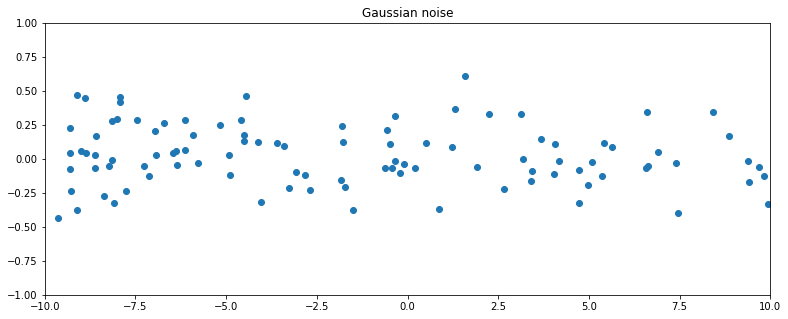

In [35]:
noise = torch.randn(y_train.shape) / 5

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title("Gaussian noise");

Каждую точку шума прибавим к соответствующей точке предыдущего графика. 

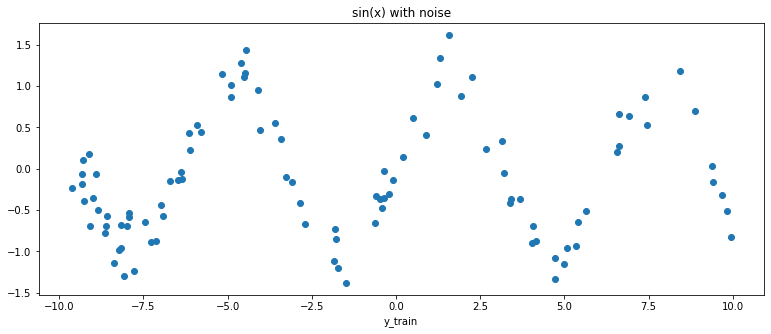

In [36]:
# TODO сложить тренировочную выборку и шум

y_train = torch.sin(x_train) + noise;

plt.plot(x_train.numpy(), y_train.numpy(), 'o') 
plt.title("sin(x) with noise")
plt.xlabel("x_train")
plt.xlabel("y_train");


Получилась обучающая выборка, имеющая место в реальном мире. Мы получили зашумленные данные, в которых виден синус.

Далее мы проверим, а сможет ли нейросеть разобаться, что здесь за функция. 

# Валидационный датасет

Создадим отдельный валидационный датасет.

Обычно, валидационный датасет является частью тренировочной выборки, однако мы знаем чистую функцию синуса и можем взять ее значения в качестве валидационного датасета.  
Стоит учесть, что в реальной жизни, валидационные данные будут также зашумлены.

Text(0.5, 0, 'y_val')

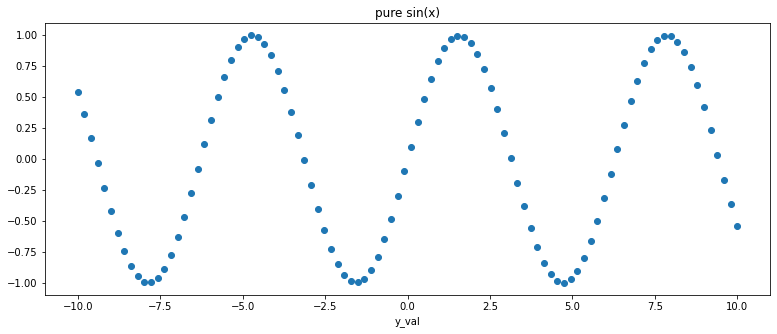

In [37]:
x_val = torch.linspace(-10, 10, 100)
y_val = torch.sin(x_val.data)

plt.plot(x_val.numpy(), y_val.numpy(), 'o') 
plt.title("pure sin(x)")
plt.xlabel("x_val")
plt.xlabel("y_val")


# Модель нейронной сети

Для начала приведем наши тензоры к правильной размерности. 

На вход нейросети должен поступать тензор, в котором каждая строчка соотвествует одному элементу, а столбцы - признакам элемента.

In [38]:
# Траснформация тензоров из строчки в столбец
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)


x_val.unsqueeze_(1)
y_val.unsqueeze_(1);

Создадим класс `SineNet`, для нейросети, которая будет решать задачу восстановления синуса. 
Этот класс, наследуем от `torch.nn.Module`, для получения дополнительных нейросетевых методов и параметров.

Далее нужно проинициализировать слои нейросети. Все слои нашей сети будут содержать одинаковое количество нейронов `n_hidden_neurons`.  

In [39]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__() # Инициализация родительского объекта
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons) #  Полносвязный слой, с одним входом и n_hidden_neurons - выходов
        self.act1 = torch.nn.Sigmoid() # Функция активации - сигмоида
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1) # Результат работы сети - один нейрон    

    # Порядок следования слоев
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

# Создадим сеть с 50-ю нейронами
sine_net = SineNet(50)

# Предсказание

Мы создали нейронную сеть `sine_net`. Теперь ее можно обучать.

Для начала, попробуем сделать предсказание с помощью необученной сети.


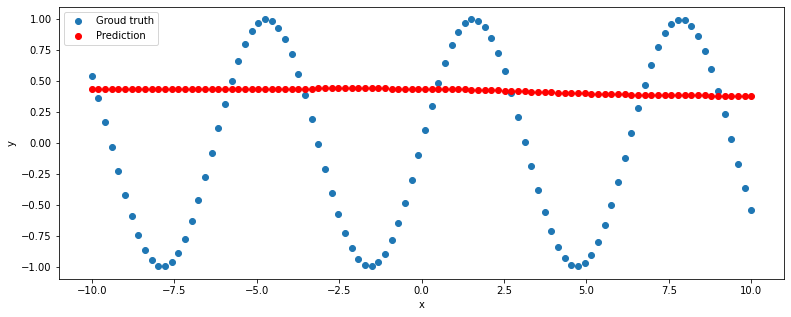

In [41]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label = "Groud truth")
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c = 'r', label = "Prediction")
    plt.legend(loc = 'upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    
predict(sine_net, x_val, y_val)

# Оптимизатор

Для обучения нейросети необходим оптимизатор.
 
Оптимизатор совершает шаги градиентного спуска.
Будем использовать [**Adam**](https://optimization.cbe.cornell.edu/index.php?title=Adam "Пояснения"), ему на вход поступают веса сети, которые хранятся в `sine_net.parameters()`.

In [42]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr = 0.01)

# Функция потерь
Также, нам необходима функция потерь - функция по которой происходит вычисление градиента. Будем использовать **MSE**.  

$MSE = \frac{1}{n}  \sum_{i = 1}^{n}(y_i - y_i')^2$

In [43]:
def loss(pred, target):
    suma = 0;
    n = len(pred);

    for i in range (0, n):
        difference = pred[i] - target[i];
        squared_difference = difference**2;
        suma += squared_difference;

    return suma/n

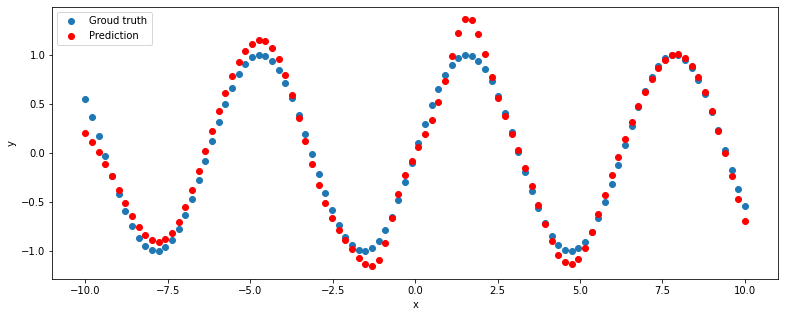

In [44]:
for epoch_index in range(2000):

    optimizer.zero_grad() # Зануляем градиенты оптимизатора

    y_pred = sine_net.forward(x_train) # Считаем предсказания, прямое распространение

    loss_val = loss(y_pred, y_train) # Считаем функцию потерь по предсказанию

    loss_val.backward() # Обратное распространение ошибки
    
    optimizer.step() # Градиентный шаг

predict(sine_net, x_val, y_val)

Подберите минимальное число нейронов, при котором предсказание сети продолжает быть удовлетворительным.

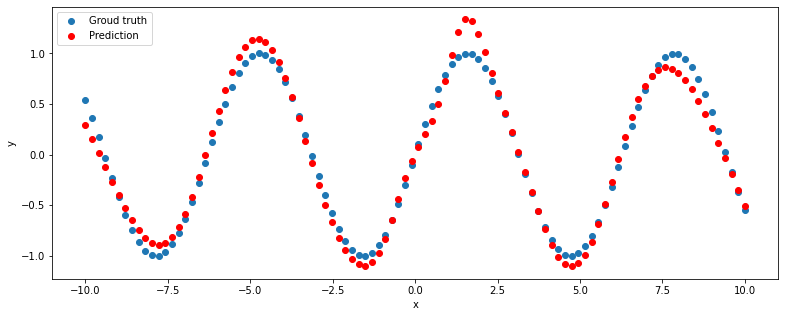

In [69]:
# TODO Подобрать минимальное количество нейронов и обучить нейросеть

net_min_neurons = SineNet(15);
optimizer_min_neurons = torch.optim.Adam(net_min_neurons.parameters(), lr=1e-3);

for epoch_index in range(8000):
    
    optimizer_min_neurons.zero_grad(); # Зануляем градиенты оптимизатора

    y_pred = net_min_neurons.forward(x_train); # Считаем предсказания, прямое распространение
    
    loss_val = loss(y_pred, y_train); # Считаем функцию потерь по предсказанию

    loss_val.backward(); # Обратное распространение ошибки

    optimizer_min_neurons.step(); # Градиентный шаг
    
    pass;

predict(net_min_neurons, x_val, y_val);

Поменяйте метод оптимизации на **SGD**. Что изменилось? Добейтесь удовлетворительного предсказания сети изменяя гиперпараметры.

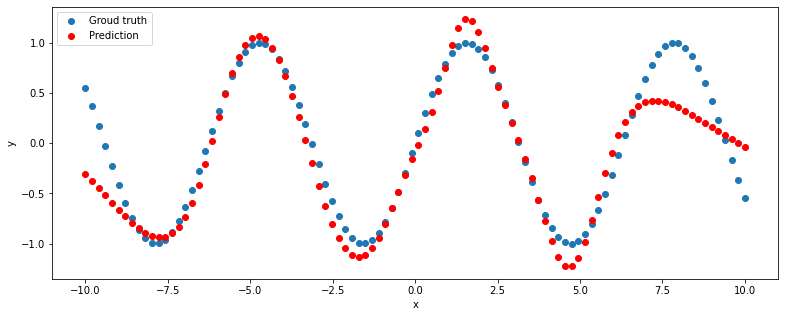

In [91]:
# TODO Изменить метод оптимизации на SGD, обучить нейросеть с наилучшими гиперпараметрами

net_with_SGD = SineNet(15);
optimizer_with_SGD = torch.optim.SGD(net_with_SGD.parameters(), lr = 0.1, momentum = 0.9);

for epoch_index in range(4000):
    
    optimizer_with_SGD.zero_grad(); # Зануляем градиенты оптимизатора

    y_pred = net_with_SGD.forward(x_train); # Считаем предсказания, прямое распространение
    
    loss_val = loss(y_pred, y_train); # Считаем функцию потерь по предсказанию

    loss_val.backward(); # Обратное распространение ошибки

    optimizer_with_SGD.step(); # Градиентный шаг
    
    pass;

predict(net_with_SGD, x_val, y_val);